<a href="https://colab.research.google.com/github/geunsu-jo/Hands-On-ML/blob/main/textbook_practice/04_training_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 선형 모델 훈련

선형 회귀 모델을 훈련하는 방법에는 크게 2가지가 있다.
- 직접 계산할 수 있는 공식을 사용해 훈련세트에 가장 잘맞는 모델을 __해석적__으로 구한다.
- __경사하강법(GD)__으로 모델 파라미터를 수정하여 훈련세트의 비용함수를 최소하하여 구한다.

## 선형 회귀

앞 장에서, RMSE(Root MSE)를 최소하하는 $\theta$를 찾았지만, MSE를 최소화 하는 $\theta$를 찾아도 결과과 같다. <br>
실제로 비용함수(Cost function)로 MSE를 사용해야 미분 특성상 계산이 단순하고, 규제(Regularization)적용이 가능하다.


### 정규 방정식

normal equation이라고 불리고, 식은 다음과 같다. <br>
$\boldsymbol{\hat{\theta}} = (\mathbf{X^{t}}\mathbf{X})^{-1}\mathbf{X^{t}}\mathbf{y}$ 

데이터를 무작위로 추출하여 정규방정식으로 계산 결과를 살펴보자

In [58]:
# 데이터 생성
import numpy as np
X = 2* np.random.rand(100, 1) # 임의의 x를 추출하여
y = 4 + 3 * X + np.random.randn(100, 1) # noise 추가

In [59]:
# summing vector 추가
X_b = np.c_[np.ones((100, 1)), X]
# theta 계산
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.26096238],
       [2.86634411]])

임의의 새로운 데이터 $\boldsymbol{x_{0}}=(0,2)^{t}$에 대한 $\hat{\mathbf{y}}_{0}$ 계산

In [60]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.26096238],
       [9.9936506 ]])

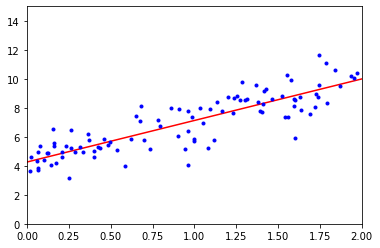

In [61]:
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

사이킷런에서 선형 회귀

In [62]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
lin_reg.intercept_, lin_reg.coef_, lin_reg.predict(X_new)

(array([4.26096238]), array([[2.86634411]]), array([[4.26096238],
        [9.9936506 ]]))

- 사이킷런을 사용하지 않은 결과와 완전히 동일
<br>

특성(feature)의 수가 샘플보다 많거나 Linear dependent여서 $(\mathbf{X}^{t}\mathbf{X})^{-1}$를 구할 수 없는 경우, __일반화 역행렬(Generalized inverse)__을 이용한다. <br>
특히, 특이값 분해(Singular Value Decomposition)으로부터 나온 __Moor-Penrose Inverse__($\mathbf{X}^{+}$)을 이용한다. <br>
$\boldsymbol{\hat{\theta}} = \mathbf{X}^{+}\mathbf{y}$

In [64]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.26096238],
       [2.86634411]])

- SVD로부터 $X=UDT^{t}$를 구한 후, D의 diagonal component가 rcond보다 작으면 0으로 바꾼 다음,  $X^{t}=TD^{+}U^{t}$를 구한다
<br>

numpy의 __np.linalg.pinv()__ 함수를 사용해도 Moor-Penrose inverse를 구할 수 있다.

In [65]:
np.linalg.pinv(X_b).dot(y)

array([[4.26096238],
       [2.86634411]])

### 계산 복잡도

$n$을 특성(feature)의 수라 할때, $X^{t}X$의 역행렬 크기는 $(n+1)*(n+1)$이고, 정규방정식의 __계산 복잡도__(Computational complexity)는 일반적으로 $O(n^{2.4})$에서 $O(n^{3})$ 사이다. 즉, 특성의 수가 2배로 늘어나면 약 5.3~8배로 증가한다. <br>하지만 사이킷런의 __LinearRegression__ 클래스가 사용하는 SVD 방법은 계산 복잡도가 $O(n^{2})$이다. 특성의 수가 2배로 늘어나면 계산 시간은 4배가 된다. <br>
$m$을 샘플의 수라 할때, 정규방정식과 SVD 모두 $O(m)$으로, 샘플이 두배가 되면 계산 시간도 선형적으로 2배가 된다.

## 경사 하강법

해석적으로 최적의 해법을 찾을 수 없을 경우, 일반적인 최적의 해를 찾는 알고리즘이다. <br>
$\boldsymbol{\theta}$을 __무작위 초기화__(random initialization)시켜 비용함수(MSE 등)을 감소하는 방향으로 $\boldsymbol{\theta}$를 업데이트 시킨다. <br>
__학습률__(learning rate, $\eta$)은 하이퍼파라미터로 적절이 튜닝되야한다.

- 학습률이 작으면 수렴을 위해 반복이 많아지므로, 시간이 매우 오래 걸림.
- 학습률이 크면 해를 찾지 못하고 발산할 수 있음.
- 지역 최솟값(local minimum)에 빠질 수 있음.
- 안장점에서 학습 속도가 느려짐(맞나?)

다행히 선형회귀에서 MSE를 비용함수로 사용하면 __볼록 함수__(convex function)으로, 최솟값은 항상 전역 최솟값(global minimum)이 보장된다.

스케일링(scaling)도 경사하강법(GD)에선 중요한 문제다.


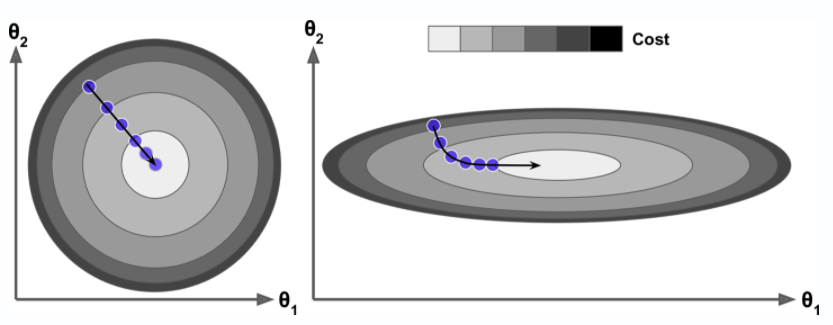

- 왼쪽의 경사하강법은 곧장 최적해로 진행되고 있지만, 스케일링이 되지 않은 오른쪽 그림은 최적해를 둘러서 진행하기 때문에 더 오랜 시간이 걸린다. 따라서 GD를 사용할 땐, 반드시 스케일링을 진행해야한다.
- 해석적인 방법(정규 방정식)으로 선형 회귀식을 구할 땐, scaling은 무시하여도 좋다.

### 배치 경사 하강법


배치 경사 하강법은 다음과 같은 스텝을 계속해서 반복한다.

$
\boldsymbol{\theta}_{(1)} = \boldsymbol{\theta}_{(0)} - \eta \dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta}) |_{\boldsymbol{\theta} = \boldsymbol{\theta}_{(0)}}
$


선형회귀이므로, 비용함수 MSE의 partial derivative는 다음과 같다.

$
\dfrac{\partial}{\partial \theta_{j}} \text{MSE}(\boldsymbol{\theta}) = \dfrac{2}{m}\sum_{i=1}^m(\boldsymbol{\theta}^{t}\mathbf{x}^{(i)} - \mathbf{y})x^{(i)}_{j}
$

vector notation으로 나타내면 다음과 같다.

$
\dfrac{\partial}{\partial \boldsymbol{\theta}} \text{MSE}(\boldsymbol{\theta})
 = \dfrac{2}{m} \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$


코드로 구현해보자.

In [66]:
eta = 0.1  # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # 랜덤 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

theta

array([[4.26096238],
       [2.86634411]])

- 정규 방정식의 결과와 동일하다.
- 매 스텝에서 훈련 데이터 전체를 사용한다.
- 따라서, 훈련 데이터가 크면 느리다.

학습률$\eta$에 따른, 경사 하강법의 스텝을 살펴보자

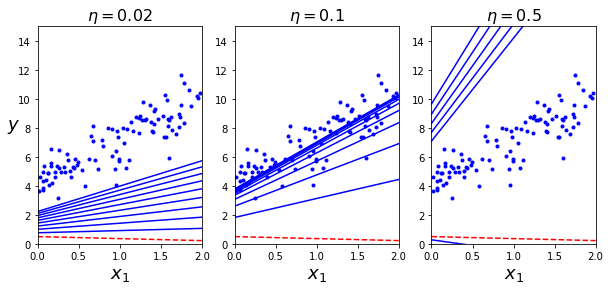

In [67]:
theta_path_bgd = [] # 나중에 배치, 확률, 미니배치 비교를 위해

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

- $\eta=0.02$이면, 수렴속도가 느리다.
- $\eta=0.5$이면, 수렴하지 못하고 발산한다.
- 즉, $\eta$는 하이퍼파리미터로 튜닝과정을 거쳐야한다.

### 확률적 경사 하강법

배치 경사 하강법에서는 매 스텝마다 전체 훈련 세트를 사용하기 때문에, 훈련세트가 많아지면 속도가 느려지는 단점을 가지고 있다. <br>
반면에 __확률적 경사 하강법__(Stocahstic GD)은 매 스텝마다 한개의 훈련 세트를 사용하기 때문에 비교적 큰 훈련세트에서 속도가 빠르다. <br>
확률적 경사 하강법은 확률적이므로 배치 경사 하강법 보다 훨씬 불안정하다. <br>
실제로 배치 경사 하강법은 스텝이 증가하면 최적해에 가까워지지만, 확률적 경사 하강법은 확률적으로 최적해에서 멀어질 수 있다. 또한 최적해 근처에서 맴도는 문제가 생긴다.(즉, 스텝이 증가하면 학습률을 줄여줘야함!) <br>
스텝이 샘플 수 m 만큼 진행되면 이를 1 __에포크__(epoch)라고 한다

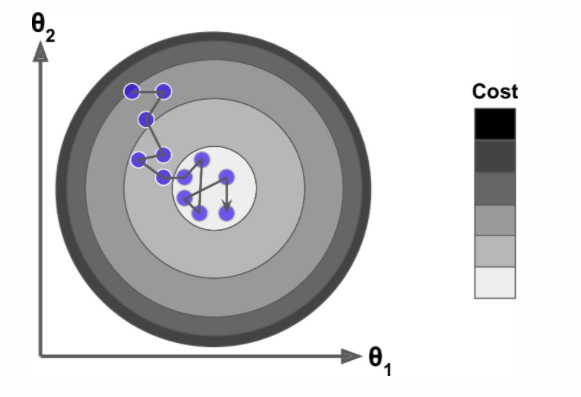

코드로 구현해보자.

In [68]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

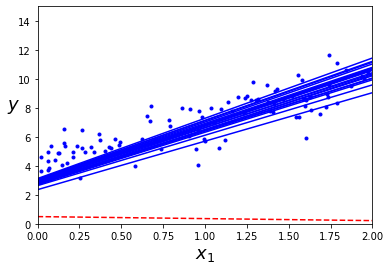

In [69]:
n_epochs = 50
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # 랜덤 초기화

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    # 첫 에포그의 20개 직선만 그림
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)          # m개 샘플 색인을 랜덤하게 1개 뽑음 
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi) # 샘플이 1개이므로 m이 빠짐
        eta = learning_schedule(epoch * m + i)       # 스텝(혹은 에포크)가 증가하면 학습률을 줄여줌
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)                 # 책에는 없음

plt.plot(X, y, "b.")                                 # 책에는 없음
plt.xlabel("$x_1$", fontsize=18)                     # 책에는 없음
plt.ylabel("$y$", rotation=0, fontsize=18)           # 책에는 없음
plt.axis([0, 2, 0, 15])                              # 책에는 없음
plt.show()           

In [70]:
theta

array([[4.25832158],
       [2.88468254]])

- 배치 경사하강법과 거의 유사하나 약간 다름

사이킷런의 __SGDRegressor__ 클래스를 사용해 확률적 경사 하강법 구현

In [71]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel()) # ravel은 다차원을 1차원으로 바꿈

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

- max_iter=1000 : 1000번의 에포크
- tol=1e-3 : 한 에포크에서 0.001보다 적게 손실이 줄어들 때까지 실행
- eta0=0.1 : 학습률 0.1(최적해에 수렴할 수 있도록, 학습률을 점점 줄여나감)

### 미니배치 경사 하강법

전체 훈련 세트를 임의의 작은 샘플 세트인 __미니배치__ 에 대해 GD를 계산하는 방법을 __미니배치 경사 하강법__이라 부른다. <br>
행렬 연산에 최적화된 하드웨어(GPU 등)를 사용하면 확률적 경사 하강법에 비해 미니배치 경사 하강법은 높은 성능을 보인다.

In [72]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [73]:
theta

array([[4.21525033],
       [2.84022308]])

In [74]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

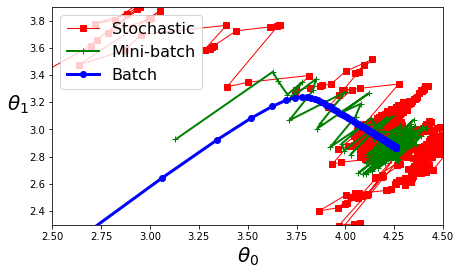

In [75]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
plt.show()

요약하자면, <br>

|알고리즘 |m이 클 때 | 외부 메모리 학습 지원 | n이 클 때| Hyper parameter | 스케일링 필요 | 사이킷런|
|---|---|---|---|---|---|---|
|정규방정식|빠름|No|느림|0| No| N/A|
|SVD|빠름|No|느림|0| No| LinearRegression|
|배치 경사 하강법|느림|No|빠름|0| Yes| SGDRegressor|
|확률적 경사 하강법|빠름|Yes|빠름|>=2| Yes| SGDRegressor|
|미니배치 경사 하강법|빠름|Yes|빠름|>=2| Yes| SGDRegressor|

## 다항 회귀

데이터가 단순한 직선(선형)이 아닌, 복잡한 비선형일 경우 데이터를 거듭제곱하여 선형 모델을 훈련시키는 기법을 __다항 회귀__(polynomial regression)라고 한다. 다항 회귀 역시 데이터가 비선형일 뿐, 회귀 계수는 선형성을 만족하기 때문에 선형모델이라고 불린다.

코드로 구현해보자

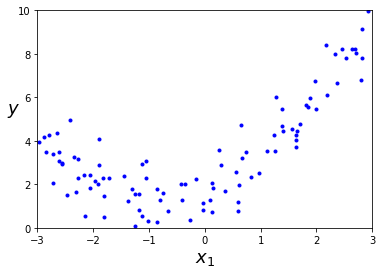

In [76]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

# 데이터 생성
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

#plot 그리기
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

- 데이터가 비선형관계이다.

사이킷런의 __PolynomialFeatures__를 사용해 위의 데이터를 2차 다항을 추가한다.

In [77]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False) # includ_bias는 편향을 위한 bias, intercpet(summing vector)
X_poly = poly_features.fit_transform(X)
X_poly[0]

array([-0.75275929,  0.56664654])

- include_bias=True를 하면, intercept를 위한 summing vector가 추가된다.
- 하지만 사이킷런의 LinearRegression은 굳이 추가하지 않더라도, intercept를 구해준다.
- 만약 절편항을 구해주지 않는 모델이라면, includ=bias=True를 넣어주자.

변환된 데이터에 __LinearRegression__을 적용

In [78]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

얻어진 회귀계수로 그림을 그려보자

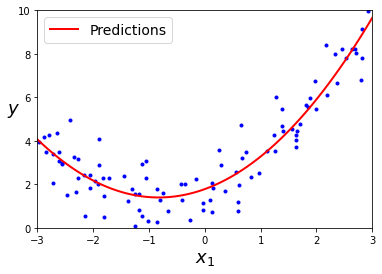

In [79]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

- 잘 적합되었음을 알 수 있다.
- __PolynomialFeatures__는 주어진 차수까지 모든 교호작용을 추가한다.
- 즉, 특성 $a$,$b$에서 degree=3으로 적용하면 $a^{2}$, $a^{3}$, $b^{2}$, $b^{3}$ ,$ab$, $a^{2}b$, $ab^{2}$ 특성이 추가된다.

다항회귀의 차수(degree)를 높이게 될 경우, 훈련 데이터에 완벽히 적합시킬 수 있다. 다음 결과를 살펴보자.

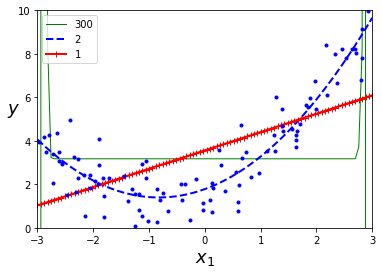

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
#            ("std_scaler", std_scaler), # 넣엇다 빼보자
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])

plt.show()

- degree=300인 경우, __과적합__(Overfitting)이 발생.
- degree=1인 경우, __과소적합__(Underfitting)이 발생.
- 해석적인 방법에선, 표준화가 필요없는데 왜 표준화를 시켰는가? > 특성 스케일이 너무 커져, 데이터를 처리 못하는 문제가 발생.

## 학습 곡선

앞서, 차수에 따른 과적합, 과소적합 문제를 시각적으로 살펴보았다. 만약 특성이 1개가 아니라 여러개라면, 시각적으로 과적합 문제를 파악하기 어렵다. 따라서 일반적인 문제에서, 훈련 세트와 검증 세트의 __학습 곡선__을 살펴보는 것이 중요하다. 

단순 선형 회귀 모델의 학습곡선을 그려보자

In [81]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # 책에는 없음
    plt.xlabel("Training set size", fontsize=14) # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)              # 책에는 없음

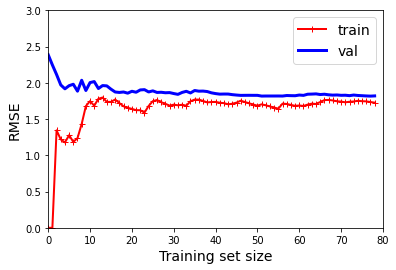

In [82]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # 책에는 없음
plt.show()   

- train과 val 그래프가 빠르게 만나거나 값이 거의 비슷한 경우 과소적합을 의심해 볼 필요가 있다.

10차 다항 회귀 모델의 학습 곡선을 그려보자

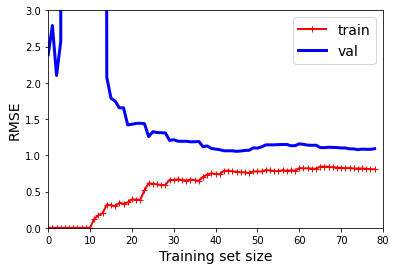

In [83]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # 책에는 없음
plt.show()  

- 훈련데이터의 오차가 선형 회귀 보다 상대적으로 낮다.
- 검증데이터의 오차가 꽤 큰 차이를 보인다.
- 따라서 과대적합을 의심해볼 필요가 있다.

## 규제가 있는 선형 모델

과대적합을 막기위해 비용 함수에 penalty를 추가하여 훈련 세트에서 만들어진 모델을 단순하게 만들도록 규제하는 방법.

In [84]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

### 릿지 회귀

$ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \dfrac{1}{2}\sum_{i=1}^{n}{\theta_i}^2 $

-  $\alpha \dfrac{1}{2}\sum_{i=1}^{n}{\theta_i}^2 $ 는 penalty term으로 $\theta$의 수가 증가하면 penalty도 함께 증가한다.
- 다항회귀의 경우 차수가 증가($\theta$의 수가 증가)할수록, penalty는 증가하고, 비용함수 $J$는 증가하게 된다.
- $\alpha$가 크면 규제가 크게 작용하고, $\alpha$가 작으면 규제는 작게 작용한다.

해석적인 방법으로 해를 구한다.

In [85]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

평균 경사 하강법(Stochastic Average Gradient Descent) 사용

In [86]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

규제 크기에 따른 그림

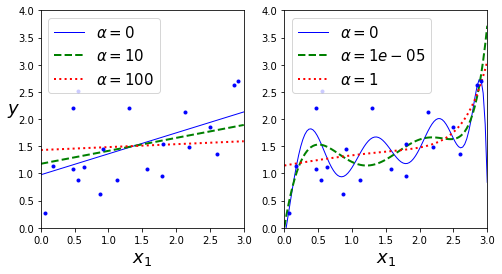

In [87]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

- 규제가 증가하면 편향이 증가하며 회귀계수가 작아짐(왼쪽 그림)을 알 수 있다.
- 규제가 증가하면 더 단순한 모델(직선에 가까운)을 만든다.

SGD모델에 $l_{2}$ 규제 적용

In [88]:
sgd_reg = SGDRegressor(penalty="l2", random_state=42, max_iter=1000, tol=1e-3)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### 라쏘 회귀

$ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum_{i=1}^{n}\left| \theta_i \right| $

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  positive)


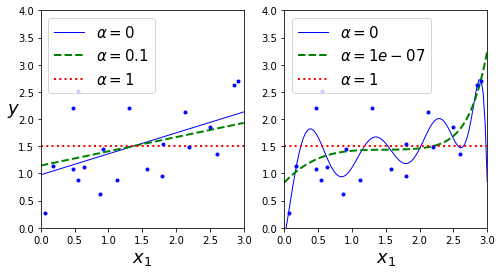

In [89]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

plt.show()

__Lasso__ 클래스를 사용한 예제

In [90]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### 엘라스틱넷

$ J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum_{i=1}^{n}{{\theta_i}^2} $

- r=0이면 ridge와 동일, r=1이면 lasso와 동일

__ElasticNet__ 클래스를 사용한 예제

In [91]:
from sklearn.linear_model import ElasticNet
# Lasso = ElasticNet(l1_ratio=1)
# Ridge는 해를 구하는 방법이 달라서 해당 안됨
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 조기 종료

조기종료 예제

In [92]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [93]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

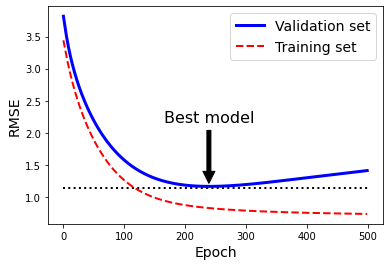

In [94]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [95]:
best_epoch, best_model

(239,
 SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
              eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
              learning_rate='constant', loss='squared_loss', max_iter=1,
              n_iter_no_change=5, penalty=None, power_t=0.25, random_state=42,
              shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
              warm_start=True))

## 로지스틱 회귀

Sigmoid Function <br>
$\sigma(t) = \frac{1}{1 + e^{-t}}$

Cost Function of 1 Obs. <br>
$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) &  \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$

Cost Function of Logistic Regression <br> 
$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$


Derivative of Cost function for Logistic Regression <br>
$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$ <br>
[proof](https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d)

데이터 로드

In [139]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [140]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [141]:
X = iris["data"][:,3:]
y = (iris["target"] == 2).astype(np.int)

__LogisticRegression__ 클래스로 로지스틱 회귀 모델 훈련

In [142]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [143]:
X_new = np.linspace(0,3,100).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
np.linspace(0,3,100).shape, X_new.shape

((100,), (100, 1))

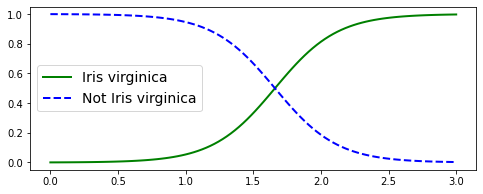

In [144]:
plt.figure(figsize=(8, 3))
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.legend(loc="center left", fontsize=14)

새로운 데이터를 예측해보자

In [145]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

## 소프트맥스 회귀

**소프트맥스 함수**

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$

**크로스 엔트로피 비용 함수**

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

**클래스 k에 대한 크로스 엔트로피의 그레이디언트 벡터**

$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$

데이터 로드

In [135]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

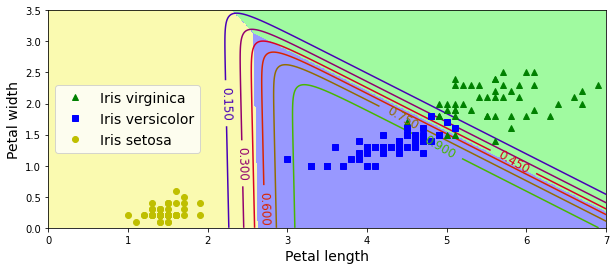

In [136]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

In [137]:
softmax_reg.predict([[5, 2]])

array([2])

In [138]:
softmax_reg.predict_log_proba([[5,2]])

array([[-14.26490421,  -2.85609209,  -0.05921261]])